<a href="https://colab.research.google.com/github/CallingKEB/AIFFEL_quest_cr/blob/main/Exploration/Ex27/EX06_project_241206.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ControlNet으로 조건을 준 이미지 생성하기

In [19]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [20]:
# Stable Diffusion 설치
!pip install --upgrade -qq git+https://github.com/huggingface/diffusers.git transformers accelerate

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [21]:
# 메모리 삭제
#torch.cuda.empty_cache()

## 윤곽선 검출

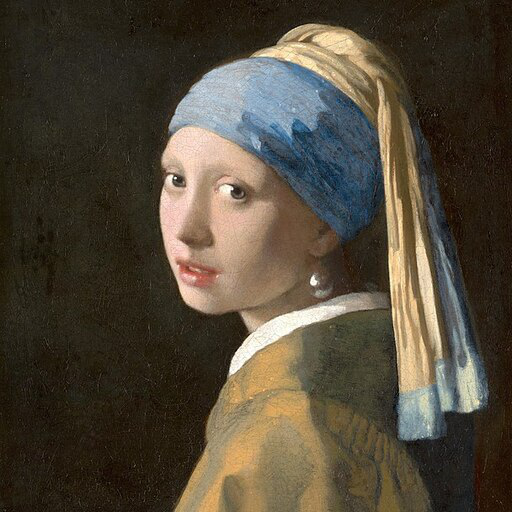

In [31]:
# 이미지 불러오기

import torch
from diffusers import StableDiffusionControlNetPipeline
from diffusers.utils import load_image

# 이미지 불러오기
image = load_image(
    "https://hf.co/datasets/huggingface/documentation-images/resolve/main/diffusers/input_image_vermeer.png"
)

image

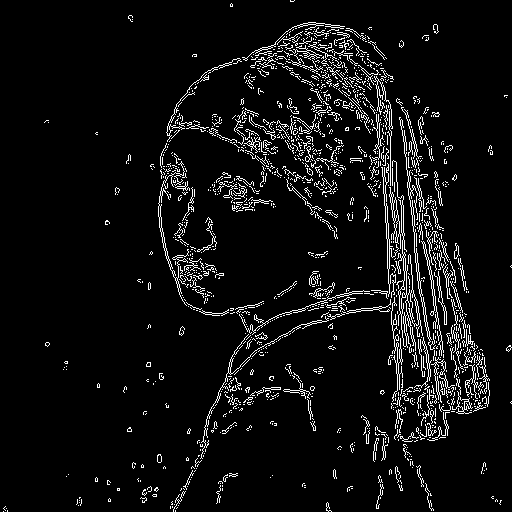

In [33]:
# OpenCV 사용하여 이미지 윤곽선 검출

import cv2
from PIL import Image
import numpy as np

# 이미지를 NumPy 배열로 변환합니다.
image = np.array(image)

# threshold를 지정합니다.
low_threshold = 100
high_threshold = 200

# 윤곽선을 검출합니다.
image = cv2.Canny(image, low_threshold, high_threshold)
image = image[:, :, None]
image = np.concatenate([image, image, image], axis=2)
canny_image = Image.fromarray(image)  # NumPy 배열을 PIL 이미지로 변환합니다.

canny_image             # canny_Image에서 윤곽선 검출한 original 버전

In [34]:
# 윤곽선 검출 전처리기를 사용한 모델 파이프라인 불러오기

from diffusers import StableDiffusionControlNetPipeline, ControlNetModel

canny_controlnet = ControlNetModel.from_pretrained("lllyasviel/sd-controlnet-canny", torch_dtype=torch.float16)
canny_pipe = StableDiffusionControlNetPipeline.from_pretrained(
    "runwayml/stable-diffusion-v1-5", controlnet=canny_controlnet, torch_dtype=torch.float16
)

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

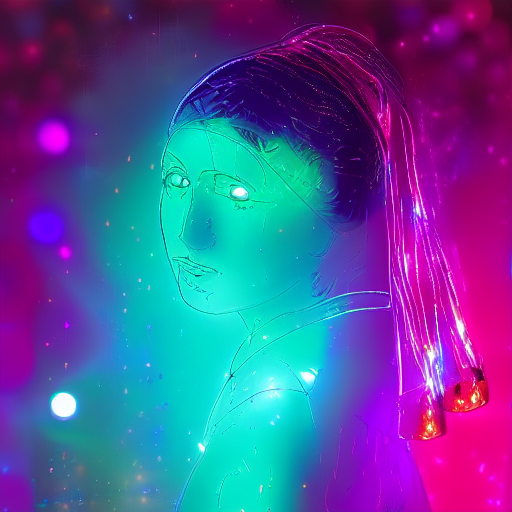

In [35]:
# 윤곽선을 추출한 이미지에 프롬프트 적용하여 새로운 이미지 생성

from diffusers import UniPCMultistepScheduler
canny_pipe.scheduler = UniPCMultistepScheduler.from_config(canny_pipe.scheduler.config)
canny_pipe = canny_pipe.to("cuda")

# 동일한 이미지를 생성하기 위해 seed를 지정합니다.
generator = torch.manual_seed(0)

# 이미지를 생성합니다.
canny_image_1 = canny_pipe(
    prompt="disco dancer with colorful lights",
    num_inference_steps=20,
    generator=generator,
    image=canny_image
).images[0]

# 생성된 이미지를 저장합니다.
canny_image_1.save("/content/drive/MyDrive/아이펠/Exploration/diffusers/canny_image_1_origin.png")

# 생성된 이미지를 출력합니다.
canny_image_1

  0%|          | 0/20 [00:00<?, ?it/s]

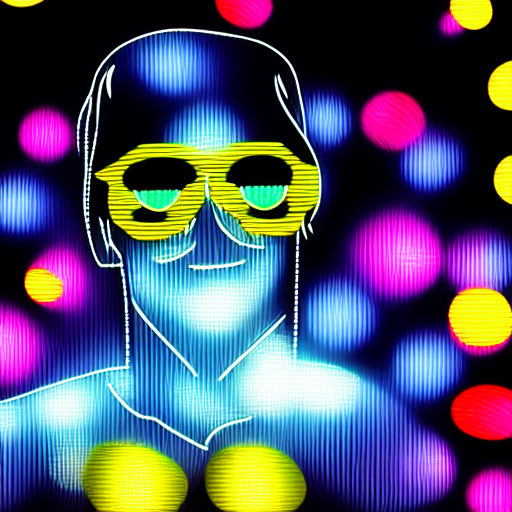

In [30]:
'''
# 이미지를 생성합니다.
canny_image = canny_pipe(
    prompt="disco dancer with colorful lights",
    num_inference_steps=20,
    generator=generator,
    image=canny_image
).images[0]

# 생성된 이미지를 저장합니다.
canny_image.save("/content/drive/MyDrive/아이펠/Exploration/diffusers/canny_image_2-001.png")

# 생성된 이미지를 출력합니다.
canny_image

# 만약 canny_image를 계속 사용하면, 원본 사진과 다르게 도출됨
'''

- negative_propmt  
원하지 않는 요소
- controlnet_conditioning_scale  
ContorlNet으로 조건을 어느 정도 주느냐를 조절. Default는 1이고, 실수값으로 설정가능
- num_inference_steps  
추론 횟수, 값이 커질수록 고해상도 이미지 출력되며 시간이 오래 걸림. default 값은 50
- guidance_scale  
얼마나 주어진 프롬프트에 근접한 이미지를 생성할지를 설정. 값이 커질수록 문자열에 근접한 이미지가 생성되지만 이미지 품질이 떨어질 수 있음. default는 7.5

## 인체 자세 감지

In [36]:
# 이미지 불러오기
# controlnet-aux를 설치합니다. Human pose를 검출해주는 controlnet의 보조용 모델입니다.
!pip install controlnet-aux==0.0.1

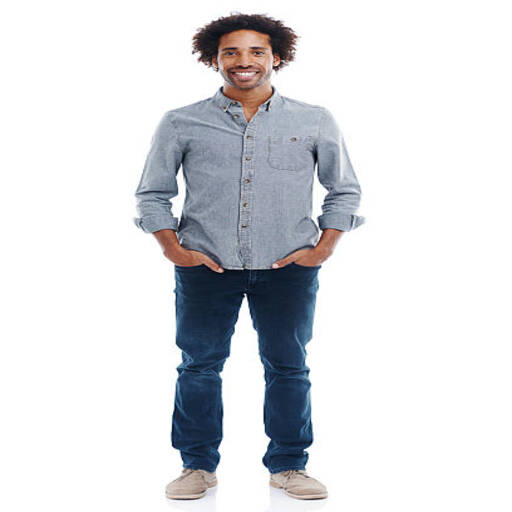

In [37]:
from diffusers.utils import load_image

openpose_image = load_image(
    "https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/diffusers/person.png"
)
openpose_image

body_pose_model.pth:   0%|          | 0.00/209M [00:00<?, ?B/s]

cuda


/usr/local/lib/python3.10/dist-packages/controlnet_aux/open_pose/body.py:17: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_dict = util.transfer(self.model, torch.load(

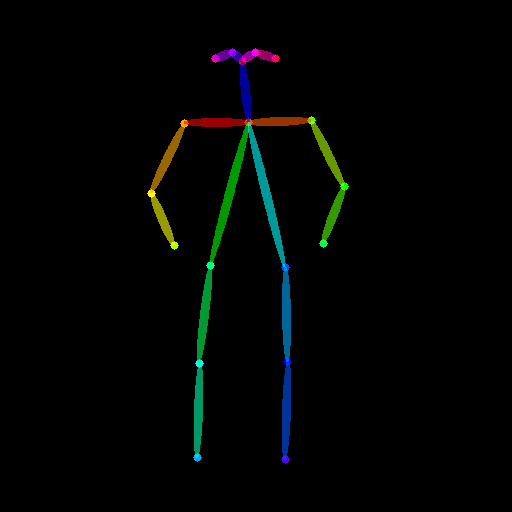

In [38]:
# Openpose 검출기 사용하여 자세만 추출
from controlnet_aux import OpenposeDetector

# 인체의 자세를 검출하는 사전 학습된 ControlNet 불러오기
openpose = OpenposeDetector.from_pretrained("lllyasviel/ControlNet")

# 이미지에서 자세 검출
openpose_image = openpose(openpose_image)
openpose_image

In [39]:
# Openpose 전처리를 사용한 모델 파이프라인
from diffusers import StableDiffusionControlNetPipeline, ControlNetModel

openpose_controlnet = ControlNetModel.from_pretrained("lllyasviel/sd-controlnet-openpose", torch_dtype=torch.float16)
openpose_pipe = StableDiffusionControlNetPipeline.from_pretrained(
    "runwayml/stable-diffusion-v1-5", controlnet=openpose_controlnet, torch_dtype=torch.float16
)

config.json:   0%|          | 0.00/920 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/1.45G [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

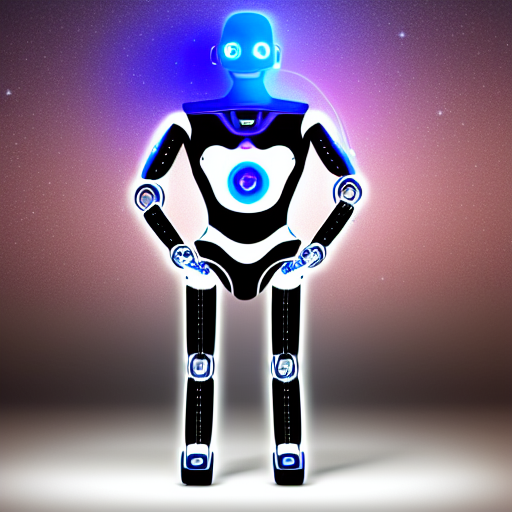

In [40]:
from diffusers import UniPCMultistepScheduler

openpose_pipe.scheduler = UniPCMultistepScheduler.from_config(openpose_pipe.scheduler.config)
openpose_pipe = openpose_pipe.to("cuda")

# Q. 코드를 작성해 보세요.
# 동일한 이미지를 생성하기 위해 seed를 넣어줍니다.
generator = torch.manual_seed(42)

#프롬프트를 작성합니다.
prompt = "A smart robot in intelligent pose with a glowing background"
negative_prompt = "blurry, low quality, cropped, overexposed"

images = openpose_image

# 이미지를 생성합니다.
openpose_image1 =  openpose_pipe(prompt=prompt, negative_prompt=negative_prompt, image=openpose_image,
                                 generator=generator, num_inference_steps=50, guidance_scale=7.5,).images[0]

# 생성된 이미지를 출력합니다.
openpose_image1

## 윤곽선 검출 + 인체 자세 감지

### Canny 알고리즘을 사용한 윤곽선 검출

In [41]:
from diffusers.utils import load_image
from PIL import Image
import cv2
import numpy as np
from diffusers.utils import load_image

# 이미지를 불러옵니다.
canny_image = load_image("https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/diffusers/input_image_vermeer.png")
canny_image = canny_image.convert("RGB")

# threshhold를 지정합니다.
low_threshold = 50
high_threshold = 150

# 이미지를 NumPy 배열로 변환합니다.
canny_image = np.array(canny_image)

# 인체 감지 포즈를 넣어줄 가운데 부분을 지워줍니다.
zero_start = canny_image.shape[1] // 4
zero_end = zero_start + canny_image.shape[1] // 2
canny_image[:, zero_start:zero_end] = 0

# 윤곽선을 검출하고 NumPy 배열을 PIL 이미지로 변환합니다.
canny_image = cv2.Canny(canny_image, low_threshold, high_threshold)
canny_image = Image.fromarray(canny_image)
canny_image = canny_image.convert("RGB")

### Openpose를 사용한 인체 자세 검출

In [42]:
# 인체 자세 검출

from controlnet_aux import OpenposeDetector
from diffusers.utils import load_image

# 이미지를 불러옵니다.
openpose_image = load_image("https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/diffusers/input_image_vermeer.png")

# OpenposeDetector를 사용하여 인체 자세를 검출합니다.
openpose = OpenposeDetector.from_pretrained("lllyasviel/ControlNet")
openpose_image = openpose(openpose_image)

cuda


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

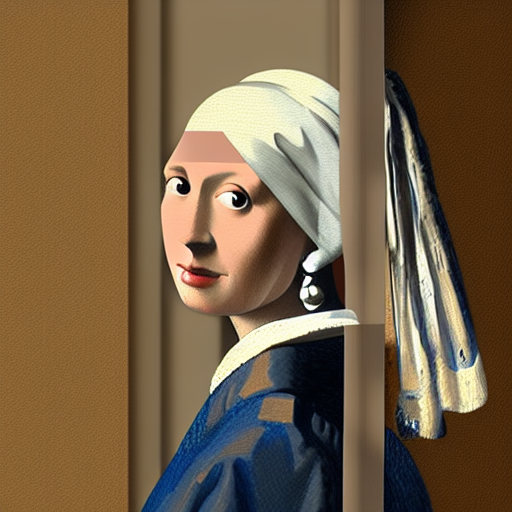

In [43]:
# Edge Detection과 Openpose, 2개의 전처리기를 controlnets라는 리스트로 만들어 파이프라인으로 전달합니다.

from diffusers import StableDiffusionControlNetPipeline, ControlNetModel, UniPCMultistepScheduler
import torch

# Edge Detection과 Openpose, 2개의 전처리기를 controlnets라는 리스트로 만듭니다.
controlnets = [
    ControlNetModel.from_pretrained("lllyasviel/sd-controlnet-openpose", torch_dtype=torch.float16),
    ControlNetModel.from_pretrained("lllyasviel/sd-controlnet-canny", torch_dtype=torch.float16)
]

# 리스트 controlnets를 파이프라인으로 전달합니다.
pipe = StableDiffusionControlNetPipeline.from_pretrained(
    "runwayml/stable-diffusion-v1-5",
    controlnet=controlnets,
    torch_dtype=torch.float16
)

pipe.scheduler = UniPCMultistepScheduler.from_config(pipe.scheduler.config)
pipe = pipe.to("cuda")

# 프롬프트를 작성합니다.
prompt = "A woman in a vermeer style painting, digital art"
negative_prompt = "low quality, blurry, distorted"

# seed를 지정합니다.
generator = torch.Generator(device="cuda").manual_seed(42)

images = [openpose_image, canny_image]

# 이미지를 생성합니다.
image = pipe(
    prompt,
    images,
    negative_prompt=negative_prompt,
    num_inference_steps=30,
    generator=generator
).images[0]

# 생성된 이미지를 저장합니다.
image.save("/content/drive/MyDrive/아이펠/Exploration/diffusers/multi_controlnet_pro_output.png")

# 생성된 이미지를 출력합니다.
image